In [1]:
import cv2
import numpy as np
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from IPython.display import Image, display

In [2]:
def getImgXPath(imgId):
    return f"./img{imgId}.jpg"

In [3]:
def cutWordFromImage(toCutImg, params):
    x,y,w,h = params
    return toCutImg[y:y+h,x:x+w]

def getPartImg(img, boundingRect):
    x,y,w,h = boundingRect
    return MyImage(img[y:y+h, x:x+w])

In [193]:
class MyImage:
    def __init__(self, img):
        # store as binary img
        self.img = cv2.threshold(img.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    def showImage(self, figsize=(10,10)):
        h, w = self.img.shape

        # Create a figure and axis for the plot
        fig, ax = plt.subplots(figsize=figsize)

        # Use imshow to display the binary image
        # cmap='gray' displays the binary image in grayscale
        ax.imshow(self.img, cmap='gray', origin='upper', extent=[0, w, h, 0])

        # Set axis labels
        ax.set_xlabel("X")
        ax.set_ylabel("Y")

        x_ticks = np.arange(0, w, 200)
        y_ticks = np.arange(0, h, 10)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)

        # Show the plot
        plt.show()
    
    def reverse(self):
        self.img = cv2.threshold(self.img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        return self
    
    def dilate(self, kernel_size=(1,1), iterations=1):
        kernel_img = np.ones(kernel_size, np.uint8)
        # az adott kernel erteke 1, ha van a kernel teruleten legalabb egy feher ertek
        self.img = cv2.dilate(self.reverse().img, kernel_img, iterations=iterations)
        self.img = self.reverse().img
        return self
    
    def connectVerticalPixels(self):
        tmp_boolean_array = np.tile(np.any(self.reverse().img, axis=0), (self.img.shape[0], 1))
        self.img = np.where(tmp_boolean_array, 255, 0).astype(np.uint8)
        return self
    
    def connectHorizontalPixels(self):
        tmp_boolean_array = np.tile(np.any(self.reverse().img, axis=1), (self.img.shape[0], 1))
        img_format = np.where(tmp_boolean_array, 255, 0).astype(np.uint8)
        self.img = np.transpose(img_format, (1, 0))
        return self
    
    def erode(self, kernel_size=(1, 1), iterations=1):
        kernel_img = np.ones(kernel_size, np.uint8)
        self.img = cv2.erode(self.reverse().img, kernel_img, iterations=iterations)
        self.img = self.reverse().img
        return self

    def getCnts(self):
        cnts = cv2.findContours(self.img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])
        return [cv2.boundingRect(c) for c in cnts]
    
    def setBorder(self, params):
        top, bottom, left, right = params
        self.img = cv2.copyMakeBorder(self.img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255,255,255])
        return self
    
    def resizeImg(self, new_height=32):
        # Calculate the new width to maintain the aspect ratio
        original_height, original_width = self.img.shape
        new_width = int((original_width / original_height) * new_height)

        # Resize the image while maintaining the aspect ratio
        self.img = cv2.resize(self.img, (new_width, new_height), interpolation=cv2.INTER_AREA)
        return self

In [194]:
class OCR(MyImage):
    custom_config = r'--oem 3 --psm 6'
    
    def __init__(self, img):
        self.original_img = img
        super().__init__(img)
        
    def showOriginalImage(self, figsize=(10,10)):
        h, w = self.original_img.shape

        # Create a figure and axis for the plot
        fig, ax = plt.subplots(figsize=figsize)

        # Use imshow to display the binary image
        # cmap='gray' displays the binary image in grayscale
        ax.imshow(self.original_img, cmap='gray', origin='upper', extent=[0, w, h, 0])

        # Set axis labels
        ax.set_xlabel("X")
        ax.set_ylabel("Y")

        x_ticks = np.arange(0, w, 200)
        y_ticks = np.arange(0, h, 10)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)

        # Show the plot
        plt.show()
        
    def ocrColumn(self, lang):
        return pytesseract.image_to_string(self.img, config = OCR.custom_config, lang=lang)
    
    def getWordsFromColumn(self, langBoolean): # OCR at 1 column
        words = []
        
        self.connectHorizontalPixels()

        
        for c in self.getCnts():
            # border widths; I set them all to 150
            top, bottom, left, right = [15]*4
            
            cutted_img = getPartImg(self.original_img, c)
            
            resized_image = MyImage(cutted_img).resizeImg(60)
#             # Calculate the new width to maintain the aspect ratio
#             original_height, original_width = cutted_img.img.shape
#             new_height = 60
#             new_width = int((original_width / original_height) * new_height)
            
#             # Resize the image while maintaining the aspect ratio
#             resized_image = MyImage(cv2.resize(cutted_img.img, (new_width, new_height), interpolation=cv2.INTER_AREA))
            resized_image = OCR(resized_image.setBorder((top, bottom, left, right)).img)

#           if langBoolean = 0 => first column which is german, else hun
            ocr_result = resized_image.ocrColumn('deu+equ' if langBoolean == 0 else 'hun')
    
            while '\n' in ocr_result:
                ocr_result = ocr_result.replace('\n', '')
                
            words.append(ocr_result)
        return words
    
    def separateTwoCols(self):
        # result black bground, two big white text chunks 
        columns = []

        cnts = self.dilate((5,5),3).connectVerticalPixels().getCnts()
        for c in cnts:
            x,y,w,h = c
            columns.append(OCR(self.original_img[y:y+h, x:x+w]))
    
        return columns
    
    def processTwoColumnImg(self):
        dict_parts = []
        cols = self.separateTwoCols()
        for idx, col in enumerate(cols):
            dict_parts.append(col.getWordsFromColumn(idx))
    
            # Use zip to combine the two arrays, filtering out empty keys and values
        my_dict = [(k, v) for k, v in zip(dict_parts[0], dict_parts[1]) if k and v]

        return dict(my_dict)

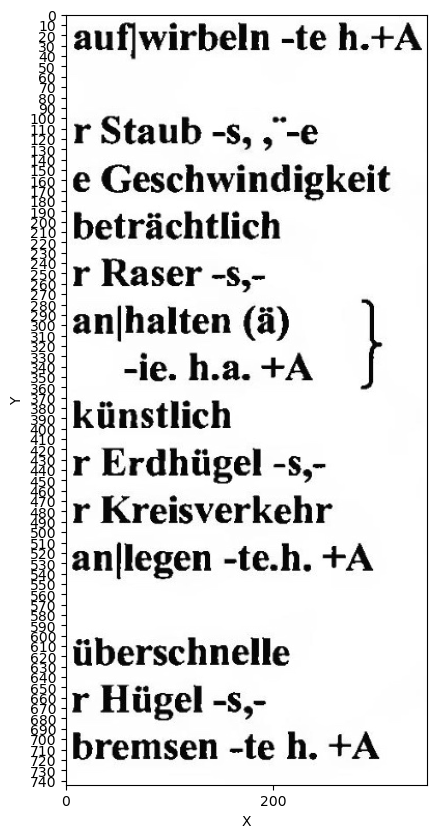

In [195]:
img2 = cv2.imread(getImgXPath(5), cv2.IMREAD_GRAYSCALE).astype(np.uint8)

test_img = OCR(img2)
col = test_img.separateTwoCols()[0]
col.showOriginalImage()

# cnts = col.erode((2,2)).connectHorizontalPixels().getCnts()
# for index, c in enumerate(cnts):
#     x,y,w,h = c
#     tmp_img = MyImage(col.original_img[y:y+h, x:x+w])
#     print(index)
#     tmp_img.showImage()
#     cv2.rectangle(col.original_img, (x,y), (x+w, y+h), (0,0,0), 2)


# col.getWordsFromColumn('deu+equ')
# ocrInstance = OCR(img2)

# # Call the dilate method on the MyImage instance
# ocrInstance.processTwoColumnImg()
# ocrInstance.showImage()

bremsen -te h. +A 
r Hügel -s,- 
überschnelle 
anllegen -te.h. +A 
r Kreisverkehr 
r Erdhügel -s,- 
künstlich 
anlhalten (ä) -ie. h.a. +A 
r Raser -s,- 
beträchtlich 
e Geschwindigkeit 
r Staub -s, ‚,-e 
auf]wirbeln -te h.+A 
fékez vt. 
domb 
túl gyors(an) 
létesít, elhelyez 
körforgalom 
földdomb 
mesterséges(en) 
megállít vkit 
száguldozó 
jelentősfen) 
sebesség 
por 
felkavar, felver vt. 


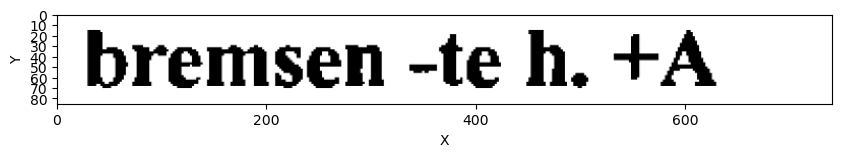

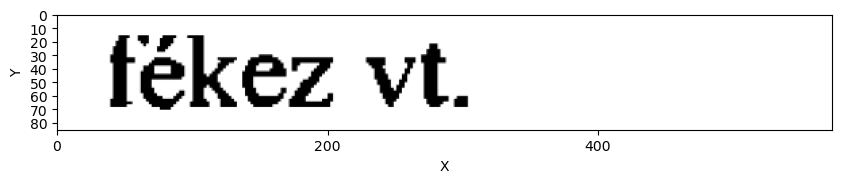

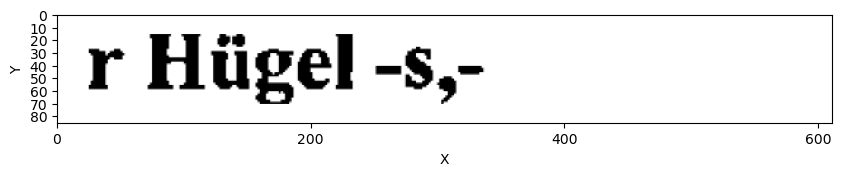

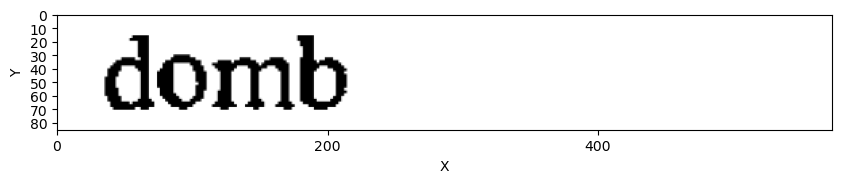

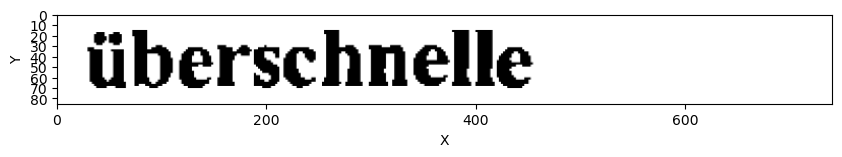

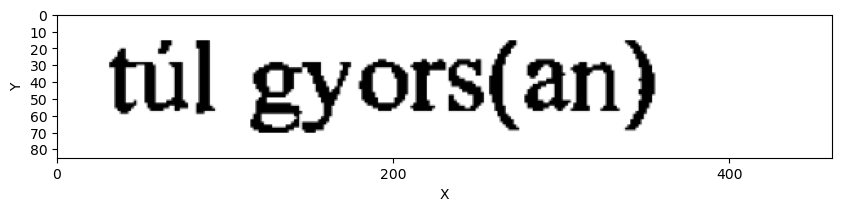

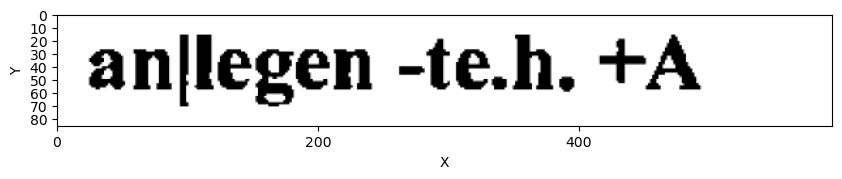

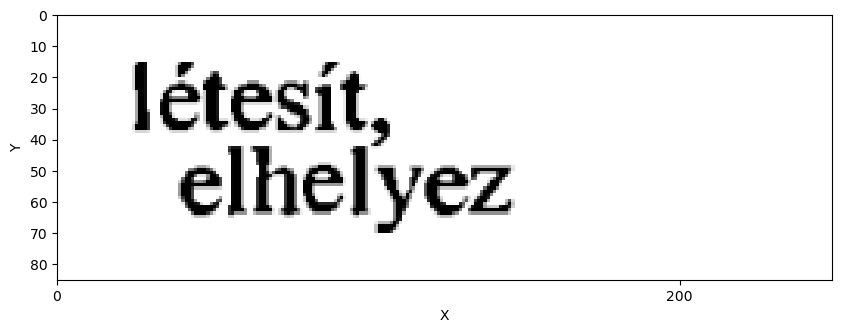

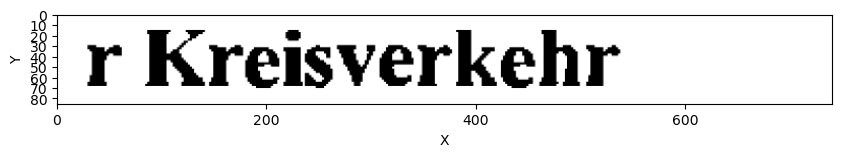

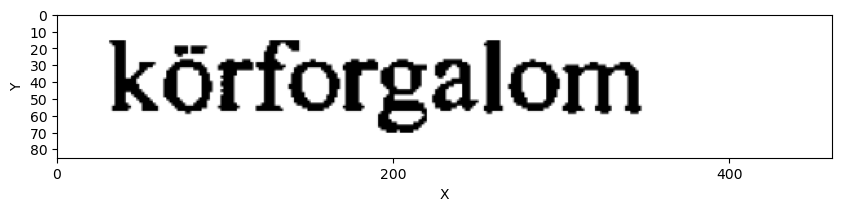

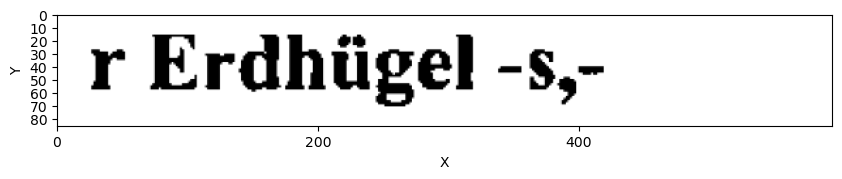

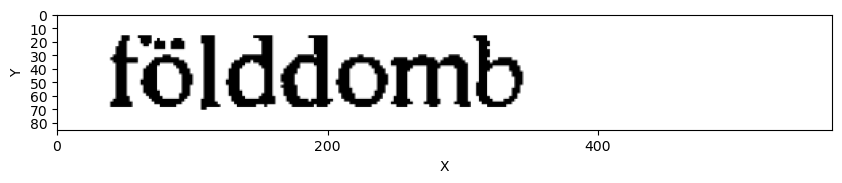

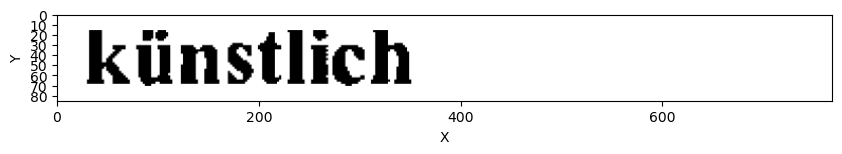

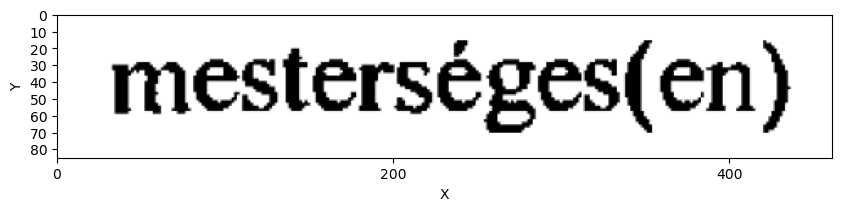

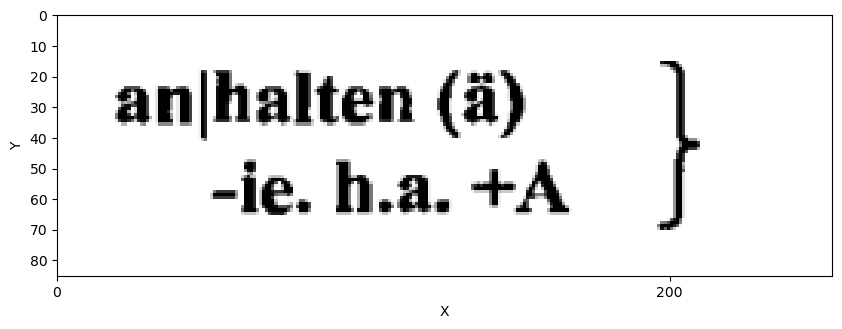

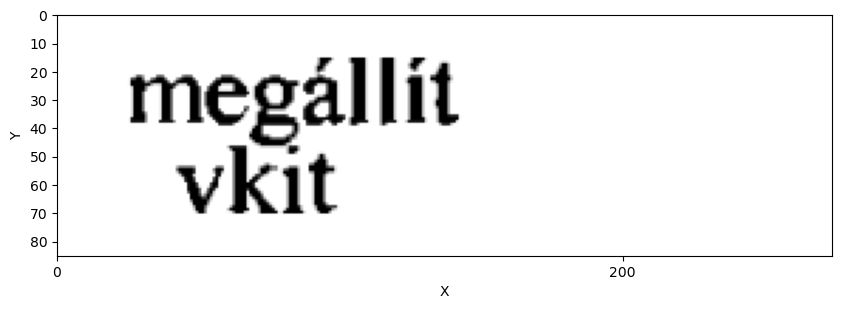

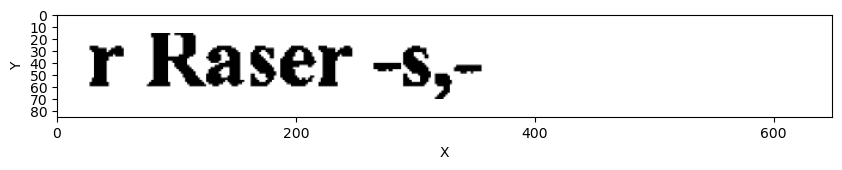

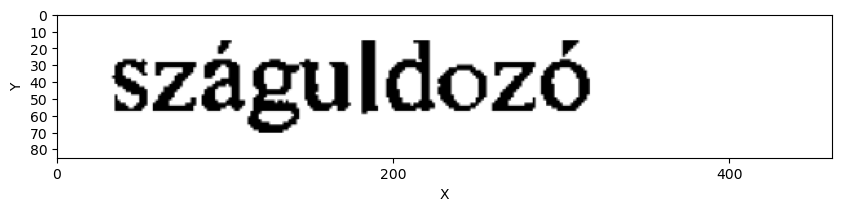

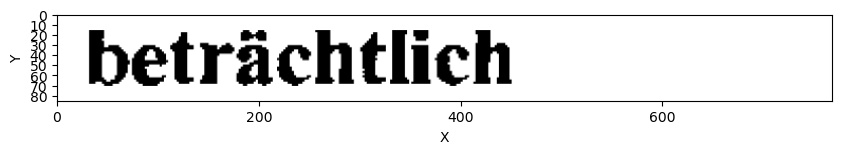

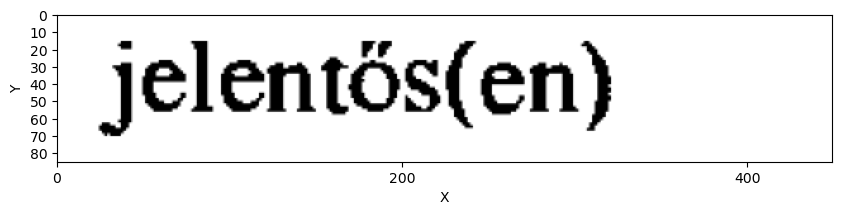

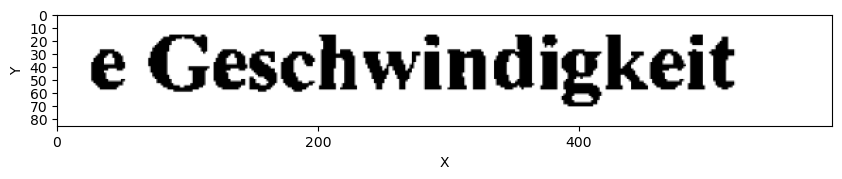

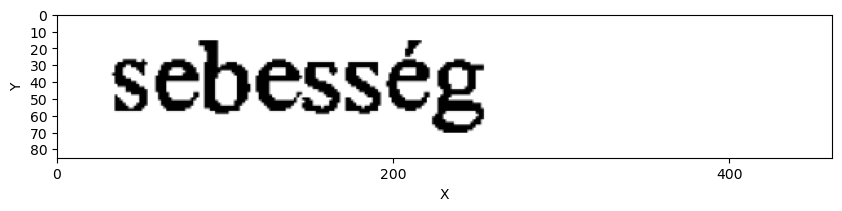

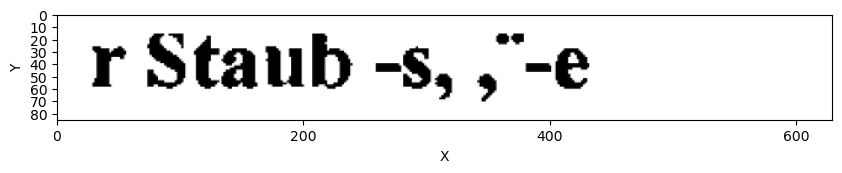

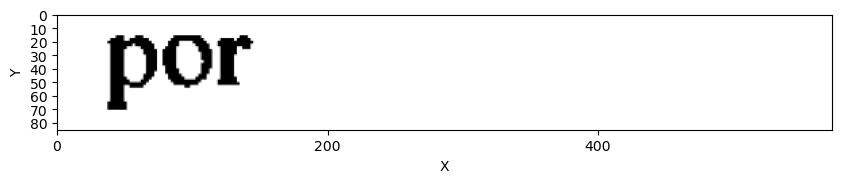

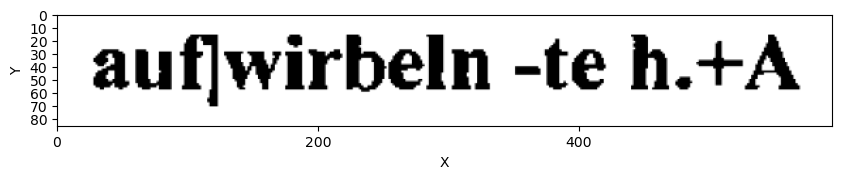

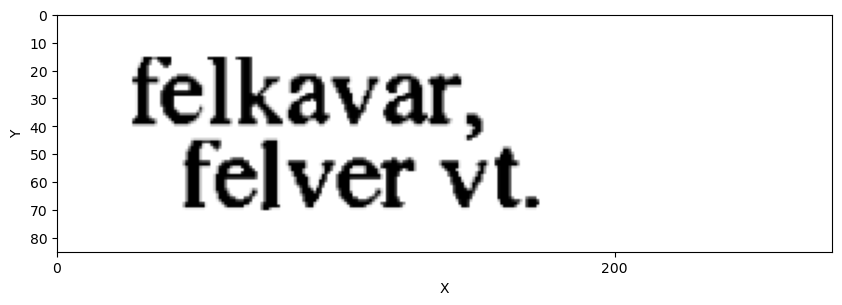

In [198]:
img2 = cv2.imread(getImgXPath(5), cv2.IMREAD_GRAYSCALE).astype(np.uint8)

test_img = OCR(img2)
cols = test_img.separateTwoCols()

final_img_col_one = []
final_img_col_two = []

for col_idx, col in enumerate(cols):
    cnts = col.erode((2, 2)).connectHorizontalPixels().getCnts()

    img_dict = {'c': [], 'x': [], 'img': []}

    for c in cnts:
        x, y, w, h = c
        img_dict['c'].append(c)

        tmp_img = OCR(col.original_img[y:y+h, x:x+w])
        img_dict['img'].append(OCR(col.original_img[y:y+h, x:x+w]))
        tmp_img_x = tmp_img.connectVerticalPixels().getCnts()[0][0]
        img_dict['x'].append(tmp_img_x)

    avg_x = int(np.average(img_dict['x']))

    skip = False
    final_img_list = final_img_col_one if col_idx == 0 else final_img_col_two
    lang = 'deu+equ' if col_idx == 0 else 'hun'

    for idx, x_value in enumerate(img_dict['x']):
        if skip:
            skip = False
            continue

        final_img = img_dict['img'][idx]

        if not (avg_x * 0.3 < x_value < avg_x * 1.7):
            curr_img, before_img = final_img.img, img_dict['img'][idx+1].img
            concatenated = np.concatenate((before_img, curr_img), axis=0)
            final_img = OCR(concatenated).resizeImg(55).setBorder((15,15,15,15))
            print(final_img.ocrColumn(lang).replace('\n',' '))
            final_img_list.append(final_img)
            skip = True
            continue

        final_img.resizeImg(55).setBorder((15,15,15,15))
        print(final_img.ocrColumn(lang).replace('\n',' '))
        final_img_list.append(final_img)

# Display images from both final_img_col_one and final_img_col_two
for i in range(len(final_img_col_one)):
    final_img_col_one[i].showImage()
    final_img_col_two[i].showImage()

In [199]:
img2 = cv2.imread(getImgXPath(5), cv2.IMREAD_GRAYSCALE).astype(np.uint8)

test_img = OCR(img2)
cols = test_img.separateTwoCols()

for col_idx, col in enumerate(cols):
    words = []
    cnts = col.erode((2, 2)).connectHorizontalPixels().getCnts()

    img_dict = {'c': [], 'x': [], 'img': []}

    for c in cnts:
        x, y, w, h = c
        img_dict['c'].append(c)

        tmp_img = OCR(col.original_img[y:y+h, x:x+w])
        img_dict['img'].append(OCR(col.original_img[y:y+h, x:x+w]))
        tmp_img_x = tmp_img.connectVerticalPixels().getCnts()[0][0]
        img_dict['x'].append(tmp_img_x)

    avg_x = int(np.average(img_dict['x']))

    skip = False
    lang = 'deu+equ' if col_idx == 0 else 'hun'

    for idx, x_value in enumerate(img_dict['x']):
        if skip:
            skip = False
            continue

        final_img = img_dict['img'][idx]

        if not (avg_x * 0.3 < x_value < avg_x * 1.7):
            curr_img, before_img = final_img.img, img_dict['img'][idx+1].img
            concatenated = np.concatenate((before_img, curr_img), axis=0)
            final_img = OCR(concatenated).resizeImg(55).setBorder((15,15,15,15))
            words.append(final_img.ocrColumn(lang).replace('\n',' '))
            skip = True
            continue

        final_img.resizeImg(55).setBorder((15,15,15,15))
        words.append(final_img.ocrColumn(lang).replace('\n',' '))

    print(words)

['bremsen -te h. +A ', 'r Hügel -s,- ', 'überschnelle ', 'anllegen -te.h. +A ', 'r Kreisverkehr ', 'r Erdhügel -s,- ', 'künstlich ', 'anlhalten (ä) -ie. h.a. +A ', 'r Raser -s,- ', 'beträchtlich ', 'e Geschwindigkeit ', 'r Staub -s, ‚,-e ', 'auf]wirbeln -te h.+A ']
['fékez vt. ', 'domb ', 'túl gyors(an) ', 'létesít, elhelyez ', 'körforgalom ', 'földdomb ', 'mesterséges(en) ', 'megállít vkit ', 'száguldozó ', 'jelentősfen) ', 'sebesség ', 'por ', 'felkavar, felver vt. ']


In [7]:
# img2 = cv2.imread(getImgXPath(3), cv2.IMREAD_GRAYSCALE).astype(np.uint8)
# img2 = MyImage(img2)

# img2.getPartImg((1, 262, 350, 33)).setBorder((15,15,15,15)).reverse()
# img2_cnts = img2.getCnts((1,1))
# bounding_rects = [cv2.boundingRect(contour) for contour in img2_cnts]

# min_y = (1000, 0)
# max_y = (0, 0)

# for i, p in enumerate(bounding_rects):
#     x,y,w,h = p
#     if (min_y[0] > y):
#         min_y = (y,i)
#     if (max_y[0] < y):
#         max_y = (y,i)
    
# x = (bounding_rects[0][0], bounding_rects[-1][0] + bounding_rects[-1][2])
# print(x)
# y = (min_y[0], max_y[0] + bounding_rects[max_y[1]][3])
# print(y)
# tmp = MyImage(img2.img[y[0]:y[1], x[0]:x[1]])
# # tmp.showImage()

# # [print(c) for c in bounding_rects]

# # img2.showImage()

In [8]:

# img2 = cv2.imread(getImgXPath(3), cv2.IMREAD_GRAYSCALE).astype(np.uint8)

# img2 = MyImage(img2)
# img2 = img2.getPartImg((1, 262, 350, 33)).setBorder((15,15,15,15))
# img2.erode((1,2),2).showImage()
# doubled_image = MyImage(cv2.resize(img2.img, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR))
# OCR(cv2.morphologyEx(doubled_image.erode((1,2),2).img, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))).ocrColumn('deu+equ')




In [9]:
# X: legkisebb x, legnagyobb x es annak a +h
# Y: legkisebb y, legnagyobb y